# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [1]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [20]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mythemeboxplot <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
            #  axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
            #  legend.title = element_blank(),
            #  legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=6, height=4.5, units=c("in"))
  # embed_font(path)
}

# Connect to DB, load data, clean data

In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [3]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT 
        package_id, 
        from_id, 
        to_id, 
        (from_semver).major AS from_semver_major, 
        (from_semver).minor AS from_semver_minor, 
        (from_semver).bug AS from_semver_bug,
        (to_semver).major AS to_semver_major, 
        (to_semver).minor AS to_semver_minor, 
        (to_semver).bug AS to_semver_bug,
        from_created,
        to_created,
        ty,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM analysis.vuln_intro_updates) as did_intro_vuln,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM analysis.vuln_patch_updates) as did_patch_vuln
    FROM analysis.all_updates
")

In [4]:
all_updates_sub <- all_updates[sample(nrow(all_updates), 100000),] 

In [5]:
all_updates <- all_updates %>% filter(ty != "zero_to_something")

In [6]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- factor(all_updates$ty, levels=c("bug", "minor", "major"))

In [7]:
head(all_updates)

,package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
1,843897,4216901,4216902,1,1,11,1,1,12,2020-07-14 11:29:08,2020-07-14 15:08:05,bug,FALSE,FALSE,bug
2,843897,4216902,4216903,1,1,12,1,2,0,2020-07-14 15:08:05,2020-07-14 16:56:02,minor,FALSE,FALSE,minor
3,843897,4216903,4216904,1,2,0,1,2,1,2020-07-14 16:56:02,2020-07-14 17:45:54,bug,FALSE,FALSE,bug
4,843897,4216904,4216905,1,2,1,1,2,2,2020-07-14 17:45:54,2020-07-14 17:49:45,bug,FALSE,FALSE,bug
5,843897,4216905,4216906,1,2,2,1,2,3,2020-07-14 17:49:45,2020-07-14 20:36:30,bug,FALSE,FALSE,bug
6,843897,4216906,4216907,1,2,3,1,2,4,2020-07-14 20:36:30,2020-07-15 08:26:36,bug,FALSE,FALSE,bug


In [8]:
patches_only <- all_updates %>% filter(did_patch_vuln == TRUE & did_intro_vuln == FALSE)
others <- all_updates %>% filter(did_patch_vuln == FALSE | did_intro_vuln == TRUE)

# select the row with ty ordered bug,minor,major for each from_id
patches_lowest_type <- patches_only %>% group_by(from_id) %>% top_n(-1, tyFact)
patches_first_created <- patches_only %>% group_by(from_id) %>% top_n(-1, to_created)

In [9]:
patches_only

package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
849985,4278123,4278124,1,0,0,1,0,1,2018-03-18 18:34:22,2020-10-29 12:53:17,bug,FALSE,TRUE,bug
849985,4278124,4278125,1,0,1,1,0,2,2020-10-29 12:53:17,2022-01-27 17:26:29,bug,FALSE,TRUE,bug
887283,4747046,4747047,1,0,1,1,0,2,2021-09-08 08:17:50,2021-09-08 13:35:35,bug,FALSE,TRUE,bug
906777,4952934,4952937,10,4,0,10,4,1,2020-11-18 19:10:38,2020-12-03 17:22:31,bug,FALSE,TRUE,bug
909109,4987053,4987054,1,1,3,1,1,4,2021-03-09 06:45:58,2021-05-24 02:45:44,bug,FALSE,TRUE,bug
930471,5212550,5212551,1,0,6,1,1,0,2018-02-07 18:14:18,2019-07-17 09:58:11,minor,FALSE,TRUE,minor
938244,5262635,5262636,1,1,1,1,1,2,2019-05-17 22:02:08,2019-05-17 22:09:15,bug,FALSE,TRUE,bug
958651,5404838,5404839,1,13,1,1,13,2,2021-01-20 15:53:53,2021-01-24 18:52:33,bug,FALSE,TRUE,bug
960509,5417258,5417259,0,8,0,0,8,2,2018-06-22 01:01:40,2019-07-18 08:02:24,bug,FALSE,TRUE,bug


# Make plots!

### What proportion of each package's update are each type?

In [10]:
# creates a data frame with one row per package, and columns for count of each update type
updateCountsByPackage <- all_updates %>%
    group_by(package_id,did_intro_vuln,did_patch_vuln,tyFact) %>%
    summarise(
        count = n()
    ) %>% 
    pivot_wider(names_from = tyFact, values_from = count, values_fill=0) %>%
    mutate(total = bug + minor + major,
           bugPct = bug / total,
           majorPct = major / total,
           minorPct = minor / total,
    ) %>%
    mutate(update_action = ifelse(did_intro_vuln, 'Intro vuln', ifelse(did_patch_vuln, 'Patch vuln', 'No security effect')))

`summarise()` has grouped output by 'package_id', 'did_intro_vuln',
'did_patch_vuln'. You can override using the `.groups` argument.


In [11]:
head(updateCountsByPackage)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,bugPct,majorPct,minorPct,update_action
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
335,FALSE,FALSE,150,182,12,344,0.4360465,0.03488372,0.5290698,No security effect
336,FALSE,FALSE,2,0,0,2,1.0000000,0.00000000,0.0000000,No security effect
337,FALSE,FALSE,1,0,0,1,1.0000000,0.00000000,0.0000000,No security effect
341,FALSE,FALSE,384,233,18,635,0.6047244,0.02834646,0.3669291,No security effect
488,FALSE,FALSE,1,0,1,2,0.5000000,0.50000000,0.0000000,No security effect
2580,FALSE,FALSE,2,1,0,3,0.6666667,0.00000000,0.3333333,No security effect


In [12]:
# make a long version of it for ggplot
updateCountsByPackageLong <- updateCountsByPackage %>%
    pivot_longer(cols=ends_with("Pct"), names_to="ty", values_to="pct")

In [13]:
updateCountsByPackageLong$update_action <- factor(updateCountsByPackageLong$update_action, levels=c('No security effect', 'Intro vuln', 'Patch vuln'))
updateCountsByPackageLong$ty <- recode(updateCountsByPackageLong$ty, bugPct='Bug', minorPct='Minor', majorPct='Major')
updateCountsByPackageLong$ty <- factor(updateCountsByPackageLong$ty, levels=c('Bug', 'Minor', 'Major'))

In [14]:
head(updateCountsByPackageLong)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,update_action,ty,pct
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
335,FALSE,FALSE,150,182,12,344,No security effect,Bug,0.43604651
335,FALSE,FALSE,150,182,12,344,No security effect,Major,0.03488372
335,FALSE,FALSE,150,182,12,344,No security effect,Minor,0.52906977
336,FALSE,FALSE,2,0,0,2,No security effect,Bug,1.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Major,0.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Minor,0.00000000


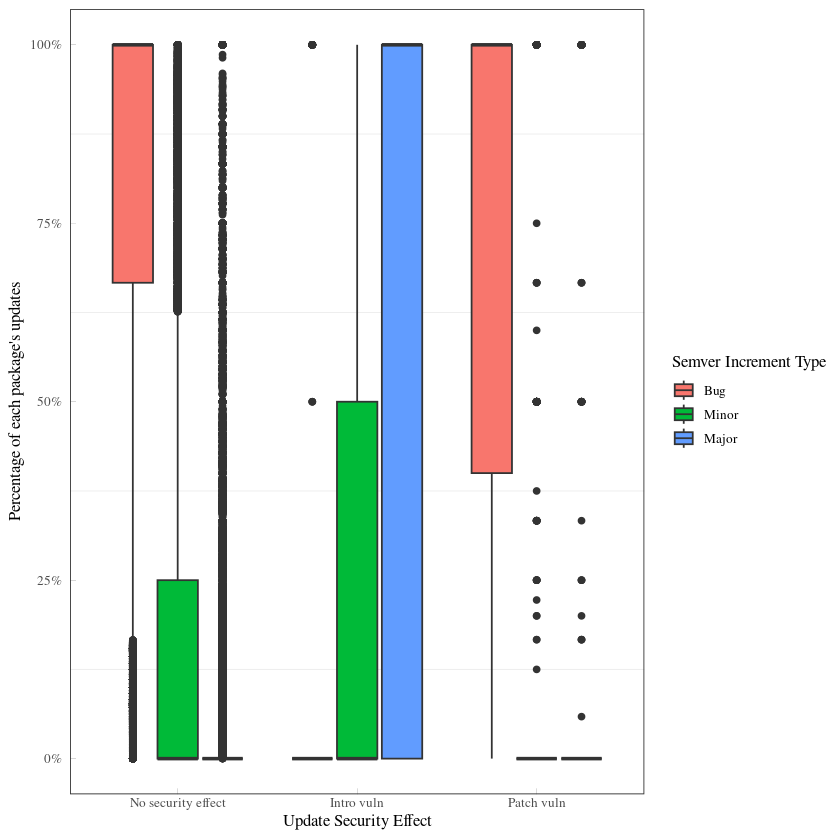

: 

In [21]:
# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = update_action, y = pct, fill=ty)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(fill='Semver Increment Type', x='Update Security Effect', y = 'Percentage of each package\'s updates') + 
    mythemeboxplot()

mysave("plots/rq2/update_type_with_security.png")